In [259]:
import numpy as np 
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
num_classes=np.unique(y).size

In [260]:
n_samples=X.shape[0]
train_split=0.8
train_size=int(n_samples*train_split)

index=np.arange(1,n_samples)
idx_perm=np.random.permutation(index)

X=X[idx_perm]
y=y[idx_perm]

X_train=X[:train_size]
y_train=y[:train_size]

X_test=X[train_size:]
y_test=y[train_size:]

In [261]:
mins=np.zeros((X_train.shape[1],1))
maxs=np.zeros((X_train.shape[1],1))

for i in range (0,X.shape[1]):
    min_=min(X_train[:,i])
    max_=max(X_train[:,i])
    X_train[:,i]=(X_train[:,i]-min_)/(max_-min_)
    mins[i]=min_
    maxs[i]=max_

for j in range (0,X.shape[1]):
    X_test[:,j]=(X_test[:,j]-mins[j])/(maxs[j]-mins[j])

In [262]:
layers=120
W_1=np.random.randn(X_train.shape[1],layers)
b_1=np.zeros((1,layers))

W_2=np.random.randn(layers,num_classes)
b_2=np.zeros((1,num_classes))

epochs=100
lr=0.001
epsilon=0.00001

mk_W1=np.zeros((X_train.shape[1],layers))
vk_W1=np.zeros((X_train.shape[1],layers))

mk_W2=np.zeros((layers,num_classes))
vk_W2=np.zeros((layers,num_classes))

mk_b1=np.zeros((1,layers))
vk_b1=np.zeros((1,layers))

mk_b2=np.zeros((1,num_classes))
vk_b2=np.zeros((1,num_classes))

delta=0.9
gamma=0.999

In [263]:
def relu(z):
    return np.maximum(0,z)

def softmax(Z):
    Z = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / np.sum(expZ, axis=1, keepdims=True)


def der_relu(z):
    dz = np.zeros_like(z)
    dz[z > 0] = 1
    return dz


def one_hot_enconding(y,num_classes):
    Y=np.zeros((len(y),num_classes))
    for i in range(0,num_classes):
        Y[y==i,i]=1
    return Y

In [264]:
Y=one_hot_enconding(y_train,num_classes)

def decoding(Y):
    y=np.zeros((Y.shape[0],1))
    print(Y.shape[0])
    for j in range(0,Y.shape[0]):
        y[j]=np.argmax(Y[j,:])
    return y

def forward_pass(W_1, W_2, b_1, b_2, X):
    z1 = X.dot(W_1) + b_1
    a1 = relu(z1)
    z2 = a1.dot(W_2) + b_2
    a2 = softmax(z2)
    return np.argmax(a2, axis=1)

loss=np.zeros((10*epochs,1))

In [265]:
def adam_optimizer(gradient,m_k,v_k):
    
    delta=0.9
    gamma=0.999

    mk=delta*m_k+(1-delta)*gradient
    vk=gamma*v_k+(1-gamma)*(gradient)**2

    return mk,vk

In [266]:
for epoch in range(1,10*epochs):
    
    # forward pass
    z1 = X_train.dot(W_1)+b_1
    a1 = relu(z1)
    z2 = a1.dot(W_2) + b_2
    a2 = softmax(z2)
    
    # gradients
    dz2 = a2 - Y
    dw2 = a1.T @ dz2 / X_train.shape[0]
    db2 = np.sum(dz2, axis=0, keepdims=True) / X_train.shape[0]

    da1 = dz2 @ W_2.T
    dz1 = da1 * der_relu(z1)

    dw1 = X_train.T @ dz1 / X_train.shape[0]
    db1 = np.sum(dz1, axis=0, keepdims=True) / X_train.shape[0]

    # adam optimizer
    
    mk_W1,vk_W1=adam_optimizer(X_train.T@dz1,mk_W1,vk_W1)
    mk_W2,vk_W2=adam_optimizer(a1.T@dz2,mk_W2,vk_W2)

    gradient_b1 = np.sum(dz1, axis=0, keepdims=True)
    gradient_b2 = np.sum(dz2, axis=0, keepdims=True)

    mk_b1,vk_b1=adam_optimizer(gradient_b1,mk_b1,vk_b1)
    mk_b2,vk_b2=adam_optimizer(gradient_b2,mk_b2,vk_b2)

    mk_W1_estimated=(mk_W1)/(1-delta**epoch)
    vk_W1_estimated=(vk_W1)/(1-gamma**epoch)
    mk_W2_estimated=(mk_W2)/(1-delta**epoch)
    vk_W2_estimated=(vk_W2)/(1-gamma**epoch)
    mk_b1_estimated=(mk_b1)/(1-delta**epoch)
    vk_b1_estimated=(vk_b1)/(1-gamma**epoch)
    mk_b2_estimated=(mk_b2)/(1-delta**epoch)
    vk_b2_estimated=(vk_b2)/(1-gamma**epoch)

    # back propagation
    W_1-=lr*(mk_W1_estimated)/(np.sqrt(vk_W1_estimated)+epsilon)
    W_2-=lr*(mk_W2_estimated)/(np.sqrt(vk_W2_estimated)+epsilon)
    b_1-=lr*(mk_b1_estimated)/(np.sqrt(vk_b1_estimated)+epsilon)
    b_2-=lr*(mk_b2_estimated)/(np.sqrt(vk_b2_estimated)+epsilon)

    L = -(1/X_train.shape[0]) * np.sum(np.sum(Y * np.log(a2),axis=1))
    loss[epoch]=L


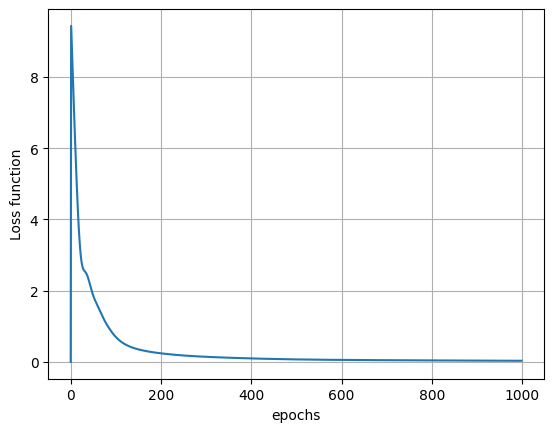

1.0


In [267]:
y_pred=forward_pass(W_1,W_2,b_1,b_2,X_test)
accuracy=np.mean(y_pred==y_test)
import matplotlib.pyplot as plt

ep=np.arange(0,10*epochs)
plt.figure()
plt.plot(ep,loss)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.grid(True)
plt.show()

print(accuracy)